In this notebook, we will use semi-supervisd GAN to build a classifier to classify SVHN data image.

To do this for the SVHN dataset, we'll turn the GAN discriminator into an 11 class discriminator. It will recognize the 10 different classes of real SVHN digits, as well as an 11th class of fake images that come from the generator. The discriminator will get to train on real labeled images, real unlabeled images, and fake images. By drawing on three sources of data instead of just one, it will generalize to the test set much better than a traditional classifier trained on only one source of data.

In [1]:
%matplotlib inline

import pickle as pkl
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: data: File exists


In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [02:07, 1.42MB/s]                              
SVHN Training Set: 64.3MB [00:22, 2.86MB/s]                            


In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

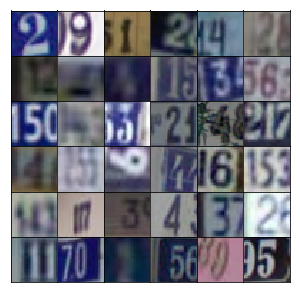

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [7]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [15]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=True, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        # The SVHN dataset comes with lots of labels, but for the purpose of this exercise,
        # we will pretend that there are only 1000.
        # We use this mask to say which labels we will allow ourselves to use.
        self.label_mask = np.zeros_like(self.train_y)
        self.label_mask[0:1000] = 1
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.train_x = self.scaler(self.train_x)
        self.valid_x = self.scaler(self.valid_x)
        self.test_x = self.scaler(self.test_x)
        self.shuffle = shuffle
        
    def batches(self, batch_size, which_set="train"):
        x_name = which_set + "_x"
        y_name = which_set + "_y"
        
        num_examples = len(getattr(dataset, y_name))
        if self.shuffle:
            idx = np.arange(num_examples)
            np.random.shuffle(idx)
            setattr(dataset, x_name, getattr(dataset, x_name)[idx])
            setattr(dataset, y_name, getattr(dataset, y_name)[idx])
            if which_set == "train":
                dataset.label_mask = dataset.label_mask[idx]
        
        dataset_x = getattr(dataset, x_name)
        dataset_y = getattr(dataset, y_name)
        for ii in range(0, num_examples, batch_size):
            x = dataset_x[ii:ii+batch_size]
            y = dataset_y[ii:ii+batch_size]
            
            if which_set == "train":
                # When we use the data for training, we need to include
                # the label mask, so we can pretend we don't have access
                # to some of the labels, as an exercise of our semi-supervised
                # learning ability
                yield x, y, self.label_mask[ii:ii+batch_size]
            else:
                yield x, y

In [16]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    y = tf.placeholder(tf.int32, (None), name='y')
    label_mask = tf.placeholder(tf.int32, (None), name='label_mask')
    
    return inputs_real, inputs_z, y, label_mask

In [21]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True, size_mult=128):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * size_mult * 4)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, size_mult * 4))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1) # leaky relu
        
        x2 = tf.layers.conv2d_transpose(x1, size_mult * 2, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2) # leaky relu
        
        x3 = tf.layers.conv2d_transpose(x2, size_mult, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3) # leaky relu
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

In [22]:
def discriminator(x, reuse=False, alpha=0.2, drop_rate=0., num_classes=10, size_mult=64):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.dropout(x, rate=drop_rate/2.5)
        
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, size_mult, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        
        x2 = tf.layers.conv2d(relu1, size_mult, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        
        
        x3 = tf.layers.conv2d(relu2, size_mult, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        
        x4 = tf.layers.conv2d(relu3, 2 * size_mult, 3, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        x5 = tf.layers.conv2d(relu4, 2 * size_mult, 3, strides=1, padding='same')
        bn5 = tf.layers.batch_normalization(x5, training=True)
        relu5 = tf.maximum(alpha * bn5, bn5)
        
        x6 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=2, padding='same')
        bn6 = tf.layers.batch_normalization(x6, training=True)
        relu6 = tf.maximum(alpha * bn6, bn6)
        relu6 = tf.layers.dropout(relu6, rate=drop_rate)
        
        x7 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=1, padding='valid')
        # Don't use bn on this layer, because bn would set the mean of each feature
        # to the bn mu parameter.
        # This layer is used for the feature matching loss, which only works if
        # the means can be different when the discriminator is run on the data than
        # when the discriminator is run on the generator samples.
        relu7 = tf.maximum(alpha * x7, x7)
        
        # Flatten it by global average pooling
        features = tf.reduce_mean(relu7, (1, 2))
        
        # Set class_logits to be the inputs to a softmax distribution over the different classes
        class_logits = tf.layers.dense(features, num_classes + extra_class)
        
        
        # Set gan_logits such that P(input is real | input) = sigmoid(gan_logits).
        # Keep in mind that class_logits gives you the probability distribution over all the real
        # classes and the fake class. You need to work out how to transform this multiclass softmax
        # distribution into a binary real-vs-fake decision that can be described with a sigmoid.
        # Numerical stability is very important.
        # You'll probably need to use this numerical stability trick:
        # log sum_i exp a_i = m + log sum_i exp(a_i - m).
        # This is numerically stable when m = max_i a_i.
        # (It helps to think about what goes wrong when...
        #   1. One value of a_i is very large
        #   2. All the values of a_i are very negative
        # This trick and this value of m fix both those cases, but the naive implementation and
        # other values of m encounter various problems)
        
        if extra_class:
            real_class_logits, fake_class_logits = tf.split(class_logits, [num_classes, 1], 1)
            assert fake_class_logits.get_shape()[1] == 1, fake_class_logits.get_shape()
            fake_class_logits = tf.squeeze(fake_class_logits)
        else:
            real_class_logits = class_logits
            fake_class_logits = 0.
        
        mx = tf.reduce_max(real_class_logits, 1, keep_dims=True)
        stable_real_class_logits = real_class_logits - mx

        gan_logits = tf.log(tf.reduce_sum(tf.exp(stable_real_class_logits), 1)) + tf.squeeze(mx) - fake_class_logits
        
        out = tf.nn.softmax(class_logits)
        
        return out, class_logits, gan_logits, features